# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).

A data analysis for 
"The Effects of Goatgrass Removal on Grassland Plant-Pollinator Interactions" by R. Nelson, S. Dritz, F. Valdovinos, & P. Aigner


*Authors*: J.-G. Young <jgyou@umich.edu> S. Dritz <sjdritz@ucdavis.edu> R. A. Nelson , <ranelson@ucdavis.edu> <br/>
*Date*: April 2022 <br/>

---

**Important Note:** In this notebook, I assume that you have installed `pystan` and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import sys
!{sys.executable} -m pip install texttable

In [2]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference_pystan3 as pp
import greedySolver2
import toolbox
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio
from tqdm import tqdm

We'll use the data matrix shown in the paper as an example. 
It comes from the Supplementary information of [this paper by Kaiser-Bunbury et al. [Nature **542**, 2017]](https://www.nature.com/articles/nature21071). It records the number of interactions between 8 plant species and 21 pollinator species. This is for a single ecosystem, as observed over the course of one month.

In [3]:
B_cols = np.loadtxt('both_network.txt', dtype = 'str', max_rows = 1)
B_rows = np.loadtxt('both_network.txt', dtype = 'str', skiprows = 1, usecols = 0)
C_cols = np.loadtxt('control_network.txt', dtype = 'str', max_rows = 1)
C_rows = np.loadtxt('control_network.txt', dtype = 'str', skiprows = 1, usecols = 0)
R_cols = np.loadtxt('restored_network.txt', dtype = 'str', max_rows = 1)
R_rows = np.loadtxt('restored_network.txt', dtype = 'str', skiprows = 1, usecols = 0)

C_plants = np.where(np.in1d(B_rows, C_rows))
C_pols = np.where(np.in1d(B_cols, C_cols))
R_plants = np.where(np.in1d(B_rows, R_rows))
R_pols = np.where(np.in1d(B_cols, R_cols))

B = np.loadtxt('both_network.nonames.txt').astype('int')
#B = ut.sort(B, B)
b_p = B.shape[0]
b_a = B.shape[1]

Let's visualize it:

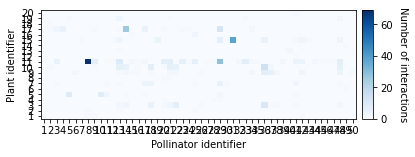

In [4]:
#control
plt.figure(figsize=(6,2))
plt.pcolormesh(B, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(b_p)) + 0.5, range(1, b_p + 1))
plt.xticks(np.array(range(b_a)) + 0.5, range(1, b_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [5]:
with open('model_pystan3.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  array[n_p, n_a] int<lower=0> M;
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  array[n_p] int M_rows = rep_array(0, n_p);
  array[n_a] int M_cols = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Priors
  r ~ exponential(0.01);
  C ~ normal(40, 20);
  rho ~ normal(0.3, 0.05);

  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
    

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [6]:
#%%capture
model = pp.compile_stan_model(B, random_seed = 1); 

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/4l/wyp88q4n7_g8p_t875nqsmh00000gn/T/httpstan_seeetv0d/model_xv2cozjg.stan', line 47, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/var/folders/4l/wyp88q4n7_g8p_t875nqsmh00000gn/T/httpstan_seeetv0d/model_xv2cozjg.stan', line 31, column 20: Argument
    0.05 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/4l/wyp88q4n7_g8p_t875nqsmh00000gn/T/httpstan_seeetv0d/model_xv2cozjg.stan', line 30, column 17: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/4l/wyp88q4n7_g8p_t875nqsmh00000gn/T/httpstan_seeetv0d/model_xv2cozjg.stan', line 30, column 13: Argument
    40 suggests there may be parameters that are not unit scale; consider
    rescaling wi

[Compiling]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [7]:
samples = pp.generate_sample(model, num_chains = 4, num_warmup=2000, num_samples=10000)
#while not pp.test_samples(samples, tol = 0.05):
#    model = pp.compile_stan_model(B)
#    samples = pp.generate_sample(model, num_chains = 4, num_warmup=2000, num_samples=10000) 

Sampling:   0%
Sampling:   0% (1/48000)
Sampling:   0% (2/48000)
Sampling:   0% (3/48000)
Sampling:   0% (4/48000)
Sampling:   0% (103/48000)
Sampling:   0% (202/48000)
Sampling:   1% (301/48000)
Sampling:   1% (400/48000)
Sampling:   1% (500/48000)
Sampling:   1% (600/48000)
Sampling:   1% (700/48000)
Sampling:   2% (800/48000)
Sampling:   2% (900/48000)
Sampling:   2% (1000/48000)
Sampling:   2% (1100/48000)
Sampling:   2% (1200/48000)
Sampling:   3% (1300/48000)
Sampling:   3% (1400/48000)
Sampling:   3% (1500/48000)
Sampling:   3% (1600/48000)
Sampling:   4% (1700/48000)
Sampling:   4% (1800/48000)
Sampling:   4% (1900/48000)
Sampling:   4% (2000/48000)
Sampling:   4% (2100/48000)
Sampling:   5% (2200/48000)
Sampling:   5% (2300/48000)
Sampling:   5% (2400/48000)
Sampling:   5% (2500/48000)
Sampling:   5% (2600/48000)
Sampling:   6% (2700/48000)
Sampling:   6% (2800/48000)
Sampling:   6% (2900/48000)
Sampling:   6% (3000/48000)
Sampling:   6% (3100/48000)
Sampling:   7% (3200/48000

Sampling:  37% (17600/48000)
Sampling:  37% (17700/48000)
Sampling:  37% (17800/48000)
Sampling:  37% (17900/48000)
Sampling:  38% (18000/48000)
Sampling:  38% (18100/48000)
Sampling:  38% (18200/48000)
Sampling:  38% (18300/48000)
Sampling:  38% (18400/48000)
Sampling:  39% (18500/48000)
Sampling:  39% (18600/48000)
Sampling:  39% (18700/48000)
Sampling:  39% (18800/48000)
Sampling:  39% (18900/48000)
Sampling:  40% (19000/48000)
Sampling:  40% (19100/48000)
Sampling:  40% (19200/48000)
Sampling:  40% (19300/48000)
Sampling:  40% (19400/48000)
Sampling:  41% (19500/48000)
Sampling:  41% (19600/48000)
Sampling:  41% (19700/48000)
Sampling:  41% (19800/48000)
Sampling:  41% (19900/48000)
Sampling:  42% (20000/48000)
Sampling:  42% (20100/48000)
Sampling:  42% (20200/48000)
Sampling:  42% (20300/48000)
Sampling:  42% (20400/48000)
Sampling:  43% (20500/48000)
Sampling:  43% (20600/48000)
Sampling:  43% (20700/48000)
Sampling:  43% (20800/48000)
Sampling:  44% (20900/48000)
Sampling:  44%

Sampling:  74% (35400/48000)
Sampling:  74% (35500/48000)
Sampling:  74% (35600/48000)
Sampling:  74% (35700/48000)
Sampling:  75% (35800/48000)
Sampling:  75% (35900/48000)
Sampling:  75% (36000/48000)
Sampling:  75% (36100/48000)
Sampling:  75% (36200/48000)
Sampling:  76% (36300/48000)
Sampling:  76% (36400/48000)
Sampling:  76% (36500/48000)
Sampling:  76% (36600/48000)
Sampling:  76% (36700/48000)
Sampling:  77% (36800/48000)
Sampling:  77% (36900/48000)
Sampling:  77% (37000/48000)
Sampling:  77% (37100/48000)
Sampling:  78% (37200/48000)
Sampling:  78% (37300/48000)
Sampling:  78% (37400/48000)
Sampling:  78% (37500/48000)
Sampling:  78% (37600/48000)
Sampling:  79% (37700/48000)
Sampling:  79% (37800/48000)
Sampling:  79% (37900/48000)
Sampling:  79% (38000/48000)
Sampling:  79% (38100/48000)
Sampling:  80% (38200/48000)
Sampling:  80% (38300/48000)
Sampling:  80% (38400/48000)
Sampling:  80% (38500/48000)
Sampling:  80% (38600/48000)
Sampling:  81% (38700/48000)
Sampling:  81%

We can see by plotting the value of the posterior distribution, evaluated for each samples, that at least one chain has gotten stuck in a minima.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

In [8]:
#CONTROL CHAIN CHECK

Text(0, 0.5, 'log posterior of rho')

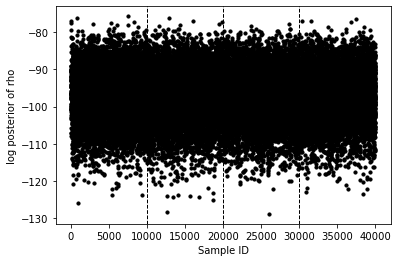

In [9]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(40000), log_probs[:,1], s=10, c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior of rho')

Text(0, 0.5, 'C')

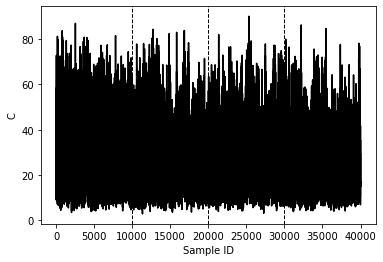

In [10]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples['C'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('C')

Text(0, 0.5, 'r')

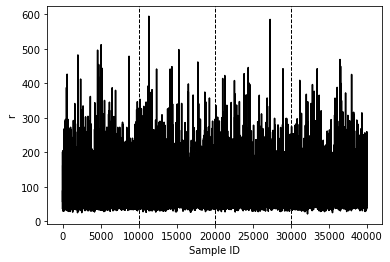

In [11]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples['r'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('r')

Text(0, 0.5, 'rho')

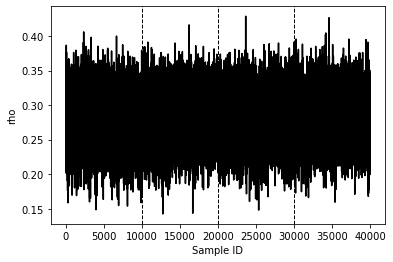

In [12]:
# re-sort restored network data so that it can be easiliy visualized by chain
chains = list(range(4)) * 10000
log_probs = np.column_stack((chains, samples['rho'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.plot(range(40000), log_probs[:,1], c='k')
for sep in [10000, 20000, 30000]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('rho')

In [13]:
# checking whether any chain got caught in a local minima
tol = 0.05
num_chains = 4
log_probs = samples['lp__'][0]
n = len(log_probs) // num_chains  # number of samples per chain
log_probs = [log_probs[list(range(i, n - (num_chains - i), num_chains))] for i in range(num_chains)]
log_probs_means = np.array([np.mean(lp) for lp in log_probs])

print("[Average Log-Probability Per Chain]")
print(log_probs_means)

print((abs(log_probs_means) - (1 - tol) * max(abs(log_probs_means)) > 0))

[Average Log-Probability Per Chain]
[-96.93027791 -96.13029557 -97.33631615 -97.43988263]
[ True  True  True  True]


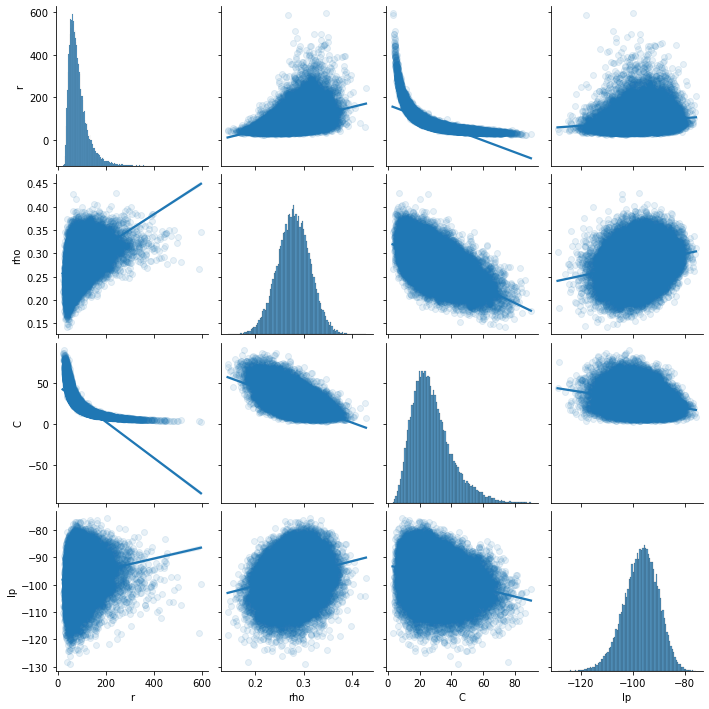

In [14]:
data = {'r': samples['r'][0], 'rho': samples['rho'][0], 'C': samples['C'][0], 'lp': samples['lp__'][0]}
df = pd.DataFrame(data)
seaborn.pairplot(df, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.1}})

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [15]:
B_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

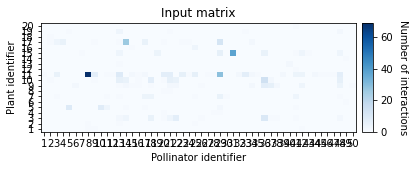

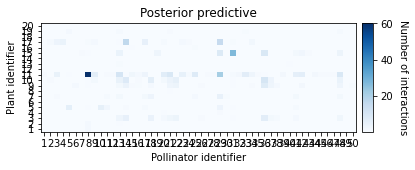

In [16]:
#Control

plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(B, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(b_p)) + 0.5, range(1, b_p + 1))
plt.xticks(np.array(range(b_a)) + 0.5, range(1, b_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(B_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(b_p)) + 0.5, range(1, b_p + 1))
plt.xticks(np.array(range(b_a)) + 0.5, range(1, b_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

Text(0, 0.5, 'Count')

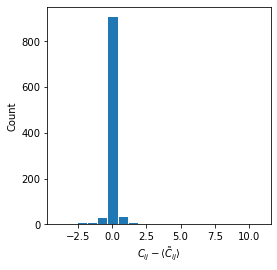

In [17]:
plt.figure(figsize=(4,4))
plt.hist((B-B_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$C_{ij}-\langle \tilde{C}_{ij}\rangle$')
plt.ylabel('Count')

Or compare the posterior predictive value to the input directly:

(-4.9, 38.0)

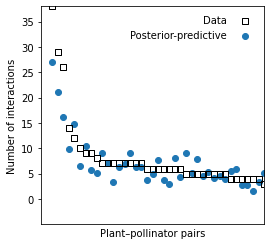

In [18]:
# Control

plt.figure(figsize=(4,4))
sort_order = np.argsort(-B.flatten())

plt.scatter(range(1, len(sort_order)+1), B.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), B_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [19]:
edge_prob = pp.estimate_network(samples)
np.savetxt('edge_probs.csv', edge_prob, delimiter = ',')

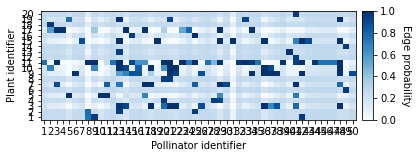

In [20]:
#control

plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(b_p)) + 0.5, range(1, b_p + 1))
plt.xticks(np.array(range(b_a)) + 0.5, range(1, b_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


The parameters themselves are contained in the `samples` object:

So we can, for example, visualize posterior distributions as:

Text(0, 0.5, 'Count')

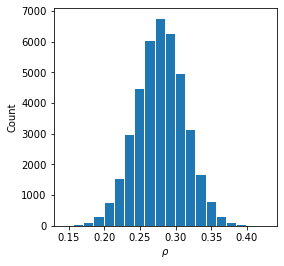

In [21]:
# control

plt.figure(figsize=(4,4))
plt.hist(samples['rho'][0], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

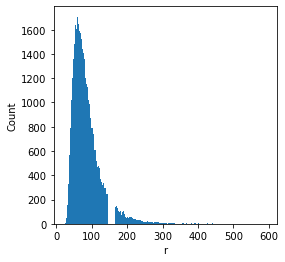

In [22]:
# control

plt.figure(figsize=(4,4))
plt.hist(samples['r'][0], density=False, bins=200, rwidth=0.9);

plt.xlabel('r')
plt.ylabel('Count')
#plt.xlim(0, 100)

And find posterior averages with:

The same thing goes for, say, the plant abundances (now a dimension `samples * n_p` object---hence why we average along the axis 0, the `samples` axis):

In [23]:
mean_sigma = np.mean(samples['sigma'], axis=1)

Text(0, 0.5, 'Effective abundance')

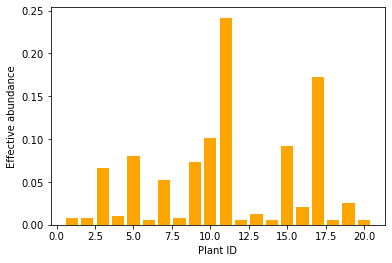

In [24]:
plt.bar([i + 1 for i in range(b_p)], mean_sigma, color='orange')
plt.xlabel('Plant ID')
plt.ylabel('Effective abundance')

We can do the same with the pollinators:

In [25]:
mean_tau = np.mean(samples['tau'], axis=1)

Text(0, 0.5, 'Effective abundance')

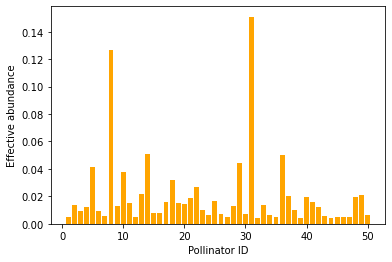

In [26]:
plt.bar([i + 1 for i in range(b_a)], mean_tau, color='orange')
plt.xlabel('Pollinator ID')
plt.ylabel('Effective abundance')

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [27]:
def nodfc(B):
    #mask = B == 0
    #rows = np.where((~mask).sum(axis=1) == 0)
    #cols = np.where((~mask).sum(axis=0) == 0)
    #B = np.delete(B, rows, axis=0)
    #B = np.delete(B, cols, axis=1)
    
    if np.all(B.sum(axis=1) != 0) & np.all(B.sum(axis=0) != 0):
        #return NestednessCalculator(B).nodf(B)
        
        # control
        C_net = B[C_plants, :]
        C_net = C_net[:, C_pols]
        nodf = toolbox.nodf(C_net)
        maxnodf = toolbox.nodf(greedySolver2.greedySolve(C_net.shape[0], C_net.shape[1], C_net.sum()))
        C = C_net.sum()
        S = C_net.shape[0] + C_net.shape[1]
        nodfc_C = (nodf/maxnodf) / (C * np.log(S))
        
        # restored
        R_net = B[R_plants, :]
        R_net = R_net[:, R_pols]
        nodf = toolbox.nodf(R_net)
        maxnodf = toolbox.nodf(greedySolver2.greedySolve(R_net.shape[0], R_net.shape[1], R_net.sum()))
        C = R_net.sum()
        S = R_net.shape[0] + R_net.shape[1]
        nodfc_R = (nodf/maxnodf) / (C * np.log(S))
        
        return nodfc_C, nodfc_R

In [28]:
# I was having trouble with the nodfc function so I just ran it here instead

num_net = 1
Q = samples['Q'].transpose((2, 0, 1))
values_c = np.zeros(Q.shape[0] * num_net)
values_r = np.zeros(Q.shape[0] * num_net)
for i, Q in tqdm(enumerate(Q)):
    for j in range(num_net):
        B = np.random.binomial(n=1, p=Q)
        
        C_net = B[C_plants[0], :]
        C_net = C_net[:, C_pols[0]]
        nodf = toolbox.nodf(C_net)
        maxnodf = toolbox.nodf(greedySolver2.greedySolve(C_net.shape[0], C_net.shape[1], C_net.sum()))
        C = C_net.sum()
        S = C_net.shape[0] + C_net.shape[1]
        nodfc_C = (nodf/maxnodf) / (C * np.log(S))
        
        # restored
        R_net = B[R_plants[0], :]
        R_net = R_net[:, R_pols[0]]
        nodf = toolbox.nodf(R_net)
        maxnodf = toolbox.nodf(greedySolver2.greedySolve(R_net.shape[0], R_net.shape[1], R_net.sum()))
        C = R_net.sum()
        S = R_net.shape[0] + R_net.shape[1]
        nodfc_R = (nodf/maxnodf) / (C * np.log(S))
        
        values_c[i * num_net + j] = nodfc_C 
        values_r[i * num_net + j] = nodfc_R

11it [00:01,  5.47it/s]/Users/Becca/Desktop/final_goatgrass_reconstruction 2/toolbox.py:59: RuntimeWarning: invalid value encountered in true_divide
  n_pairs = po_mat[neg_delta] / (2.0 * deg_minima[neg_delta])
40000it [2:26:33,  4.55it/s] 


Again, we provide a simpler interface to make the calculation:

In [29]:
#posterior_values_nodf_c, posterior_values_nodf_r = pp.get_network_property_distribution(samples, nodfc)
posterior_values_nodf_c = values_c[~np.isnan(values_c)]
posterior_values_nodf_r = values_r[~np.isnan(values_r)]

We find, in this case:

(0.0, 0.003)

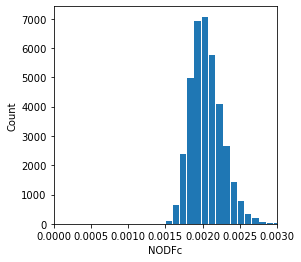

In [30]:
# control

plt.figure(figsize=(4,4))
plt.hist(posterior_values_nodf_c, density=False, bins=20, rwidth=0.9);

plt.xlabel('NODFc')
plt.ylabel('Count')
plt.xlim(0, 0.003)

(0.0, 0.003)

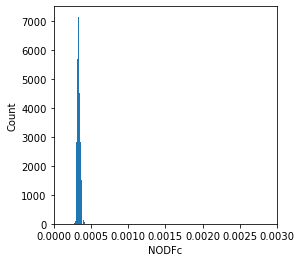

In [31]:
# restored

plt.figure(figsize=(4,4))
plt.hist(posterior_values_nodf_r, density=False, bins=20, rwidth=0.9);

plt.xlabel('NODFc')
plt.ylabel('Count')
plt.xlim(0, 0.003)

In [32]:
print(np.max(posterior_values_nodf_c))
print(np.max(posterior_values_nodf_r))

print(np.mean(posterior_values_nodf_c))
print(np.mean(posterior_values_nodf_r))

0.003342268897934051
0.00047897680679188334
0.0020547452405762405
0.00033786315402154323


In [33]:
#Create finalized figure for paper

# Further information: 

"*[Reconstruction of plant–pollinator networks from observational data](https://www.biorxiv.org/content/10.1101/754077v1)*"<br/>
[J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/)<br/>
bioRxiv:754077 (2019)


Or get in touch at <jgyou@umich.edu> and on [github](https://github.com/jg-you/plant-pol-inference)!

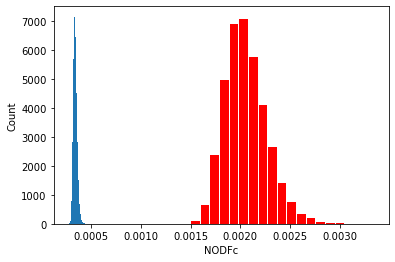

In [34]:
from matplotlib import pyplot as plt

#plt.figure(figsize=(4,4))
plt.hist(posterior_values_nodf_r, density=False, bins=20, rwidth=0.9)
plt.hist(posterior_values_nodf_c, density=False, bins=20, rwidth=0.9, color="red");
plt.xlabel('NODFc')
plt.ylabel('Count')
plt.show()

#plt.xlim(0, 0.003)
